In [1]:
import numpy as np
import pymc3 as pm
import scipy as sp
import scipy.stats as st
from theano import tensor as tt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
import theano
import arviz as az

In [4]:
(5,) + (3, 4)

(5, 3, 4)

In [2]:
from pymc3.distributions.dist_math import bound, factln, binomln, betaln, logpow, random_choice
from pymc3.distributions.distribution import Discrete, draw_values, generate_samples

In [3]:
class Error(pm.Discrete):
    def __init__(self, mu, *args, **kwargs):
        super(Error, self).__init__(*args, **kwargs)
        #self.theta = theta
        #self.alpha = alpha
        #self.beta = beta
        self.mu = mu
        self.mode = self.mean = mu
            
    def random(self, point=None):                
        raise ValueError()

    def logp(self, value):              
#         theta, alpha, beta = self.theta, self.alpha, self.beta        
#         data = value.data
#         logp = float(0)
#         for i in range(data.shape[1]):            
#             for el in data[:,i]:
#                 if el:
#                     logp += logpow(p, el) + logpow(1 - p, 1 - el)
#                     logp += tt.log(theta * (1 - beta) + (1 - theta) * alpha)
#                 else:
#                     logp += tt.log(theta * beta + (1 - theta) * (1 - alpha))        
#         return logp
        mu = self.mu
        log_prob = bound(
            logpow(mu, value) - factln(value) - mu,
            mu >= 0, value >= 0)
        # Return zero when mu and value are both zero
        return tt.switch(tt.eq(mu, 0) * tt.eq(value, 0), 0, log_prob)



In [29]:
def stick_breaking(beta):
    p = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * p

In [32]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=5)
    w = pm.Deterministic('w', stick_breaking(beta))

In [33]:
with model:
    trace = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:01<00:00, 1155.92draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8975252174355856, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


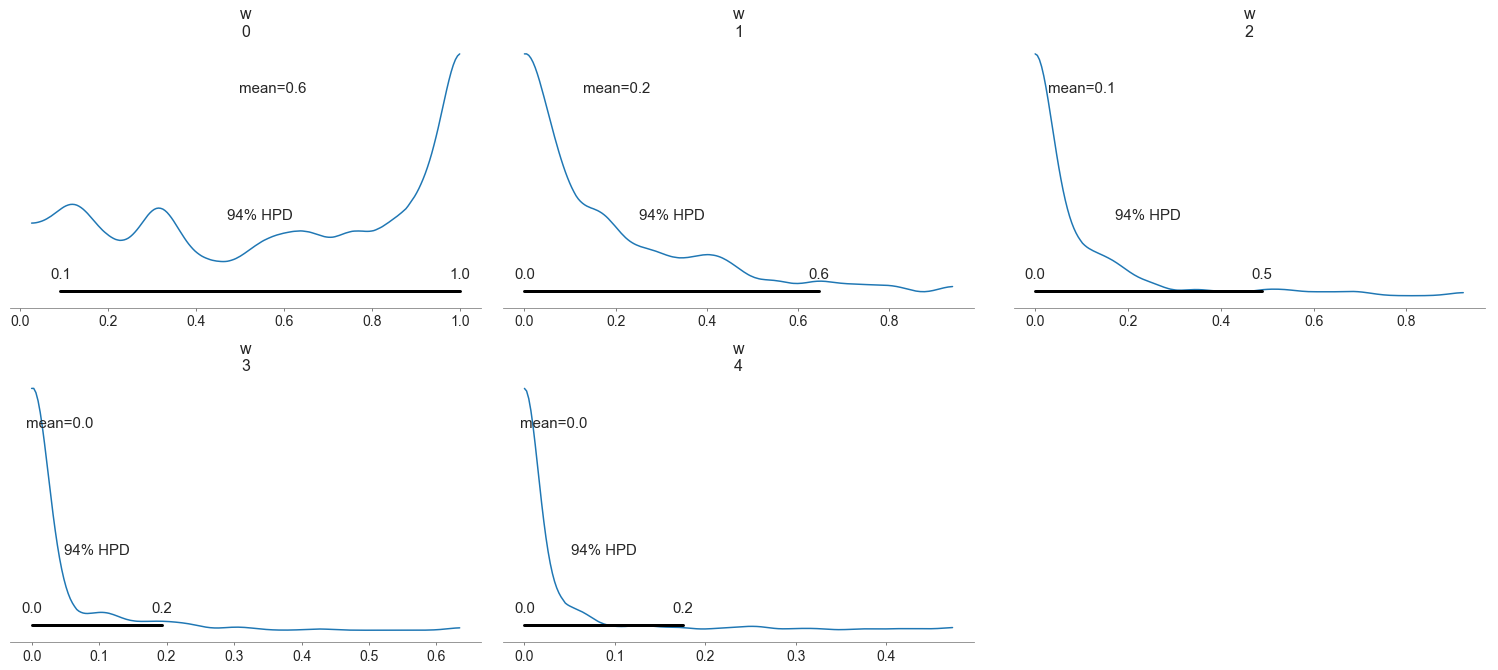

In [45]:
az.plot_posterior(trace, var_names="w");

In [26]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
np.arange(10)[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [21]:
stick_breaking(1)

Elemwise{mul,no_inplace}.0

In [10]:
np.random.seed(23)
data1 = sp.stats.poisson.rvs(1, size=50)
data2 = sp.stats.poisson.rvs(10, size=50)
data3 = sp.stats.poisson.rvs(20, size=50)
data = sp.append(data1, sp.append(data2, data3))

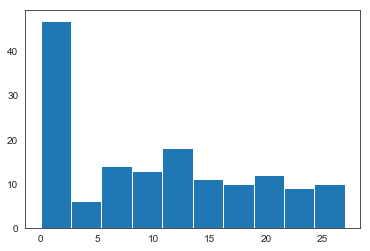

In [11]:
plt.hist(data);

TypeError: Invalid dimensions for image data

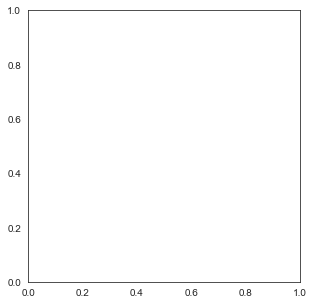

In [5]:
plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(data), "Greys")
plt.axis("off")
plt.title("Data", loc="left")
plt.show()

In [13]:
def stick_breaking(beta):
    p = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    w = beta * p
    w = w / w.sum()
    return w

In [34]:
K =3

In [35]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    error_alpha = pm.Uniform("ea", lower=0, upper=1, shape=K)
    error_beta = pm.Uniform("eb", lower=0, upper=1, shape=K)
    error_theta = pm.Uniform("et", lower=0, upper=1, shape=K)

    dens = [
        Error.dist(error_theta[i], error_alpha[i], error_theta[i])
        for i in range(K)
    ]
    like = pm.Mixture('x', w=w, comp_dists=dens, observed=data)

TypeError: Discrete classes expect dtype to be int16 or int64.

In [120]:
def stick_breaking(beta):
    p = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    w = beta * p
    w = w / w.sum()
    return w

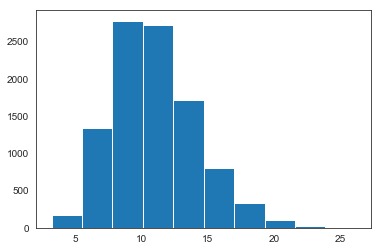

In [212]:
plt.hist(scipy.stats.gamma.rvs(10, 1, size=10000));

In [124]:
K = 10
alpha = 5

In [213]:
with pm.Model() as model:    
    beta = pm.Beta('beta', 1, .5, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    
    error_mu = pm.Gamma("et", 10, 1, shape=K)    
    
    comps = [
        pm.Poisson.dist(mu=error_mu[i])    
        for i in range(K)
    ]
    like = pm.Mixture('x', w=w, comp_dists=comps, observed=data)

In [214]:
with model:    
    trace = pm.sample(1000, chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [et, beta]
100%|██████████| 1500/1500 [00:12<00:00, 122.92it/s]
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


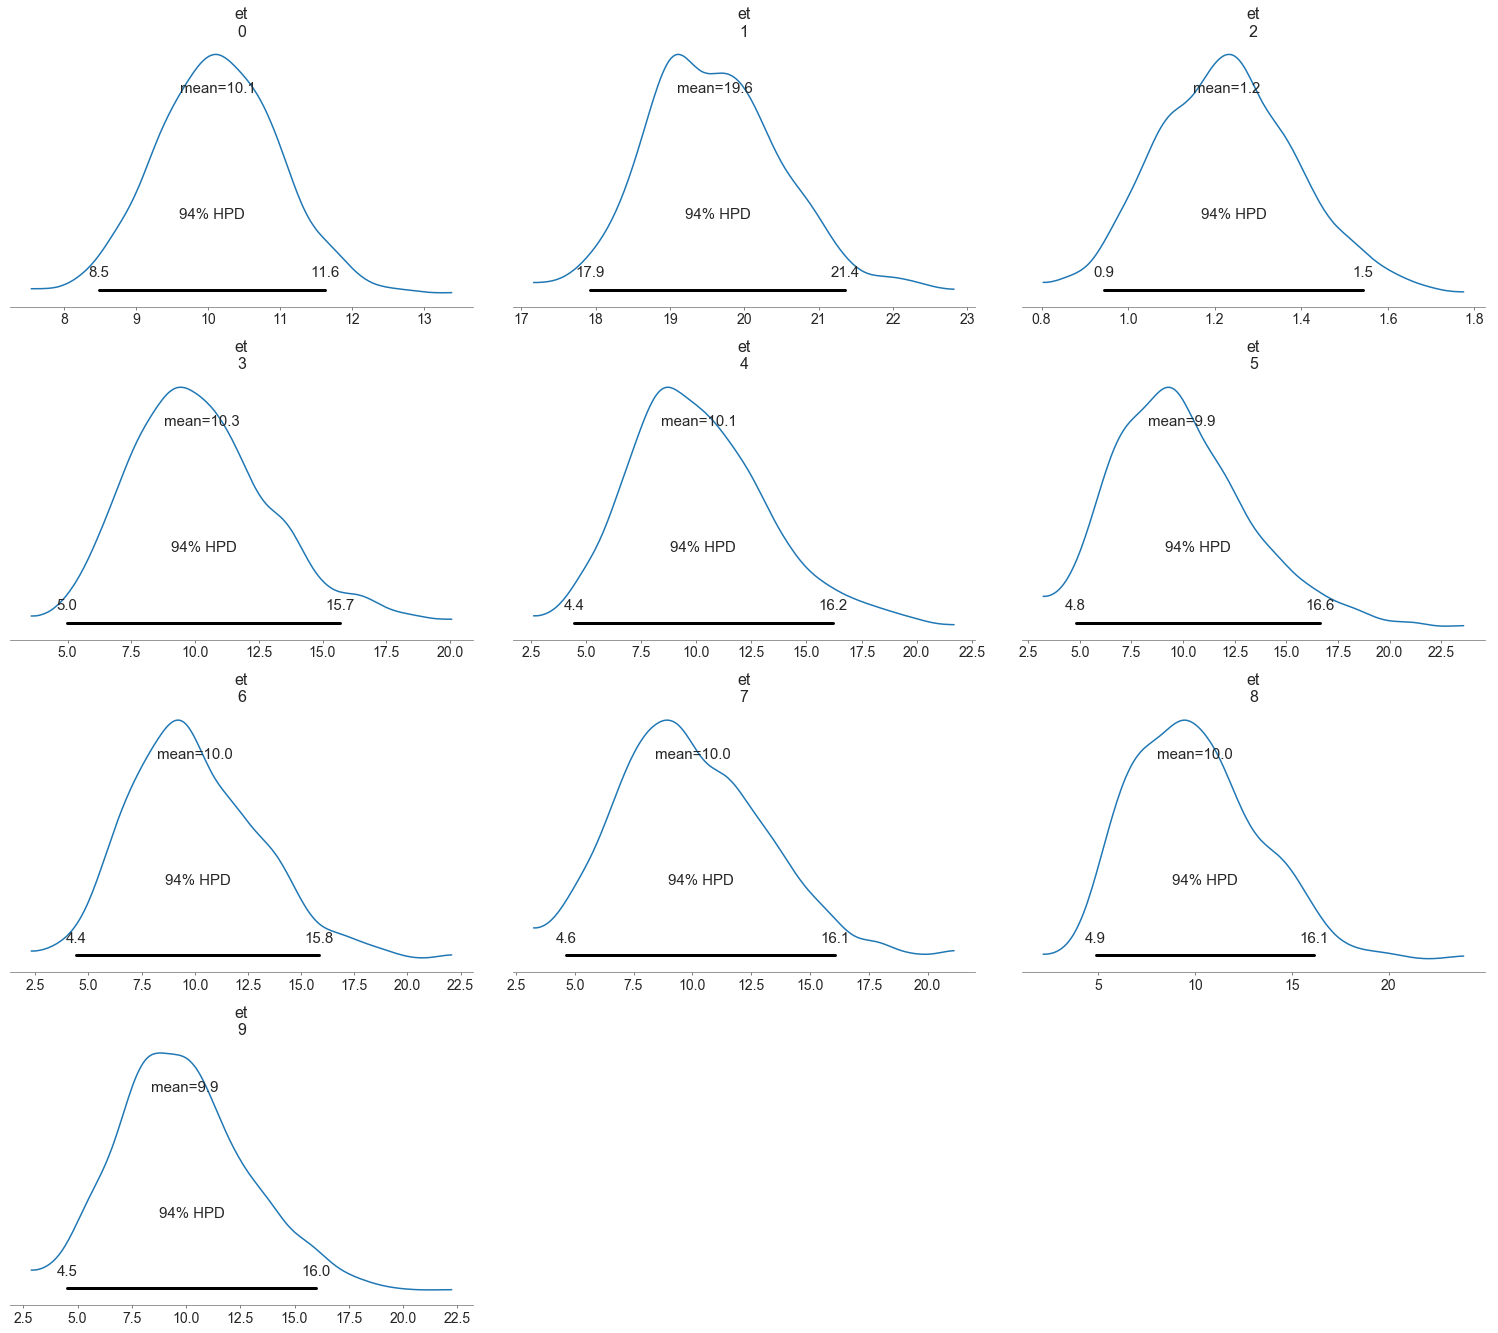

In [215]:
az.plot_posterior(trace, var_names='et');

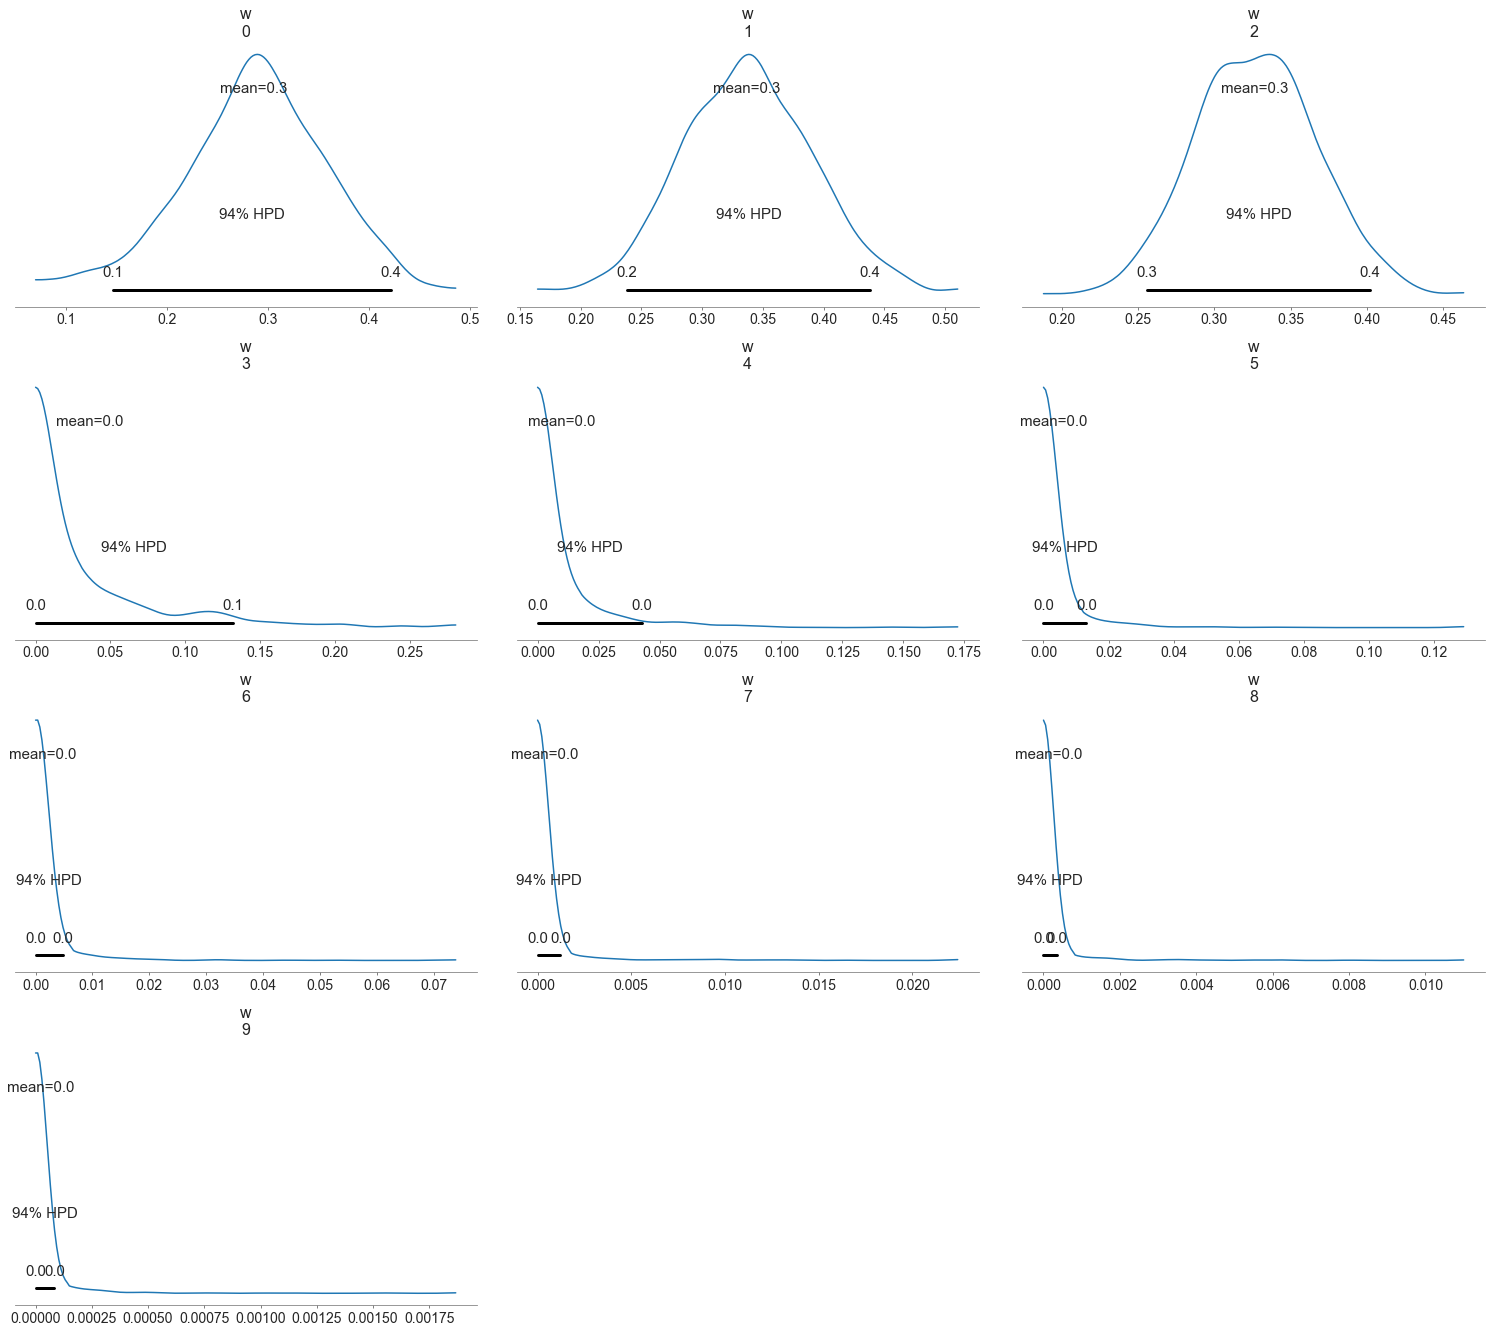

In [216]:
az.plot_posterior(trace, var_names='w');

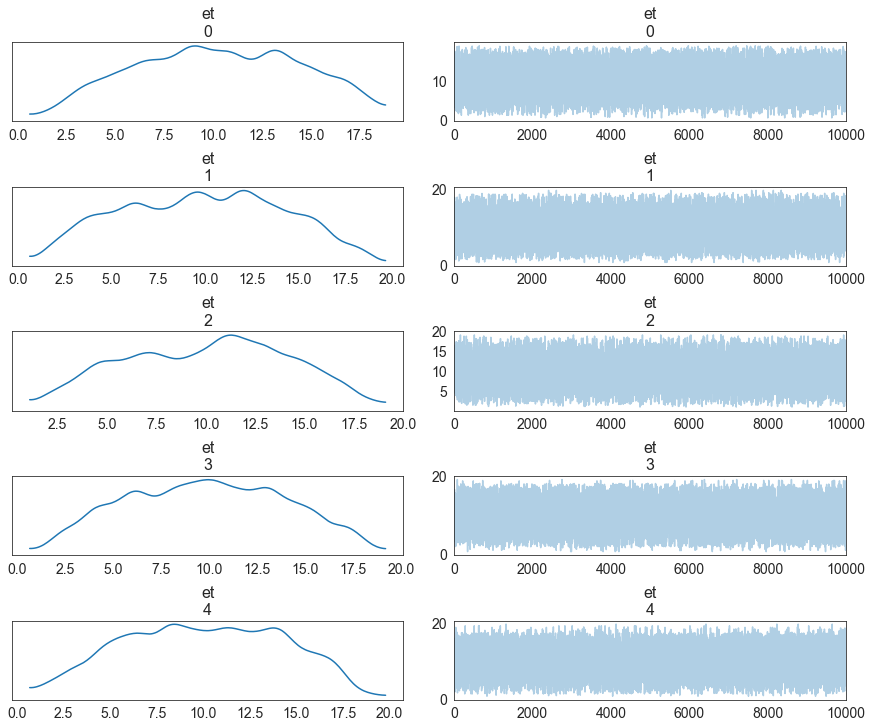

In [247]:
az.plot_trace(trace, var_names="et");

In [6]:
N = 20 
P = 3

In [7]:
np.random.seed(23)
data1 = sp.stats.bernoulli.rvs(.1, size=N * P).reshape((N, P))
data2 = sp.stats.bernoulli.rvs(.5, size=N * P).reshape((N, P))
data3 = sp.stats.bernoulli.rvs(.9, size=N * P).reshape((N, P))
data = sp.row_stack((data1, data2, data3))

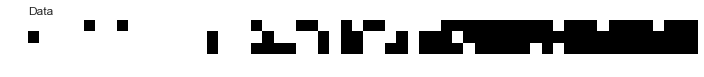

In [8]:
plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(data), "Greys")
plt.axis("off")
plt.title("Data", loc="left")
plt.show()

In [33]:
def stick_breaking(beta):
    p = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * p

In [10]:
def bmix_logp(comp, mus):
    def _logp(value):
        mus_comp = mus[comp, :]        
        pos = value * tt.log(mus_comp)
        neg = (1 - value) * tt.log((1-mus_comp))
        comb = pos + neg
        overall_sum = tt.sum(comb)
        return overall_sum
    return _logp

In [9]:
K = 10

with pm.Model() as model: 
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    
    mu = pm.Beta('mu', 1, 1, shape=K)
    obs = pm.Mixture('obs', w,  
                 pm.Bernoulli.dist(mu, shape=(P, K)),
                 shape=K, 
                 observed=data.reshape((N * 3, P, 1)))

NameError: name 'stick_breaking' is not defined

In [30]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, random_seed=23)
    ppc = pm.sample_posterior_predictive(trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [beta]
>Metropolis: [alpha]
  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (180,) (60,3) 

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


ValueError: cannot convert float NaN to integer

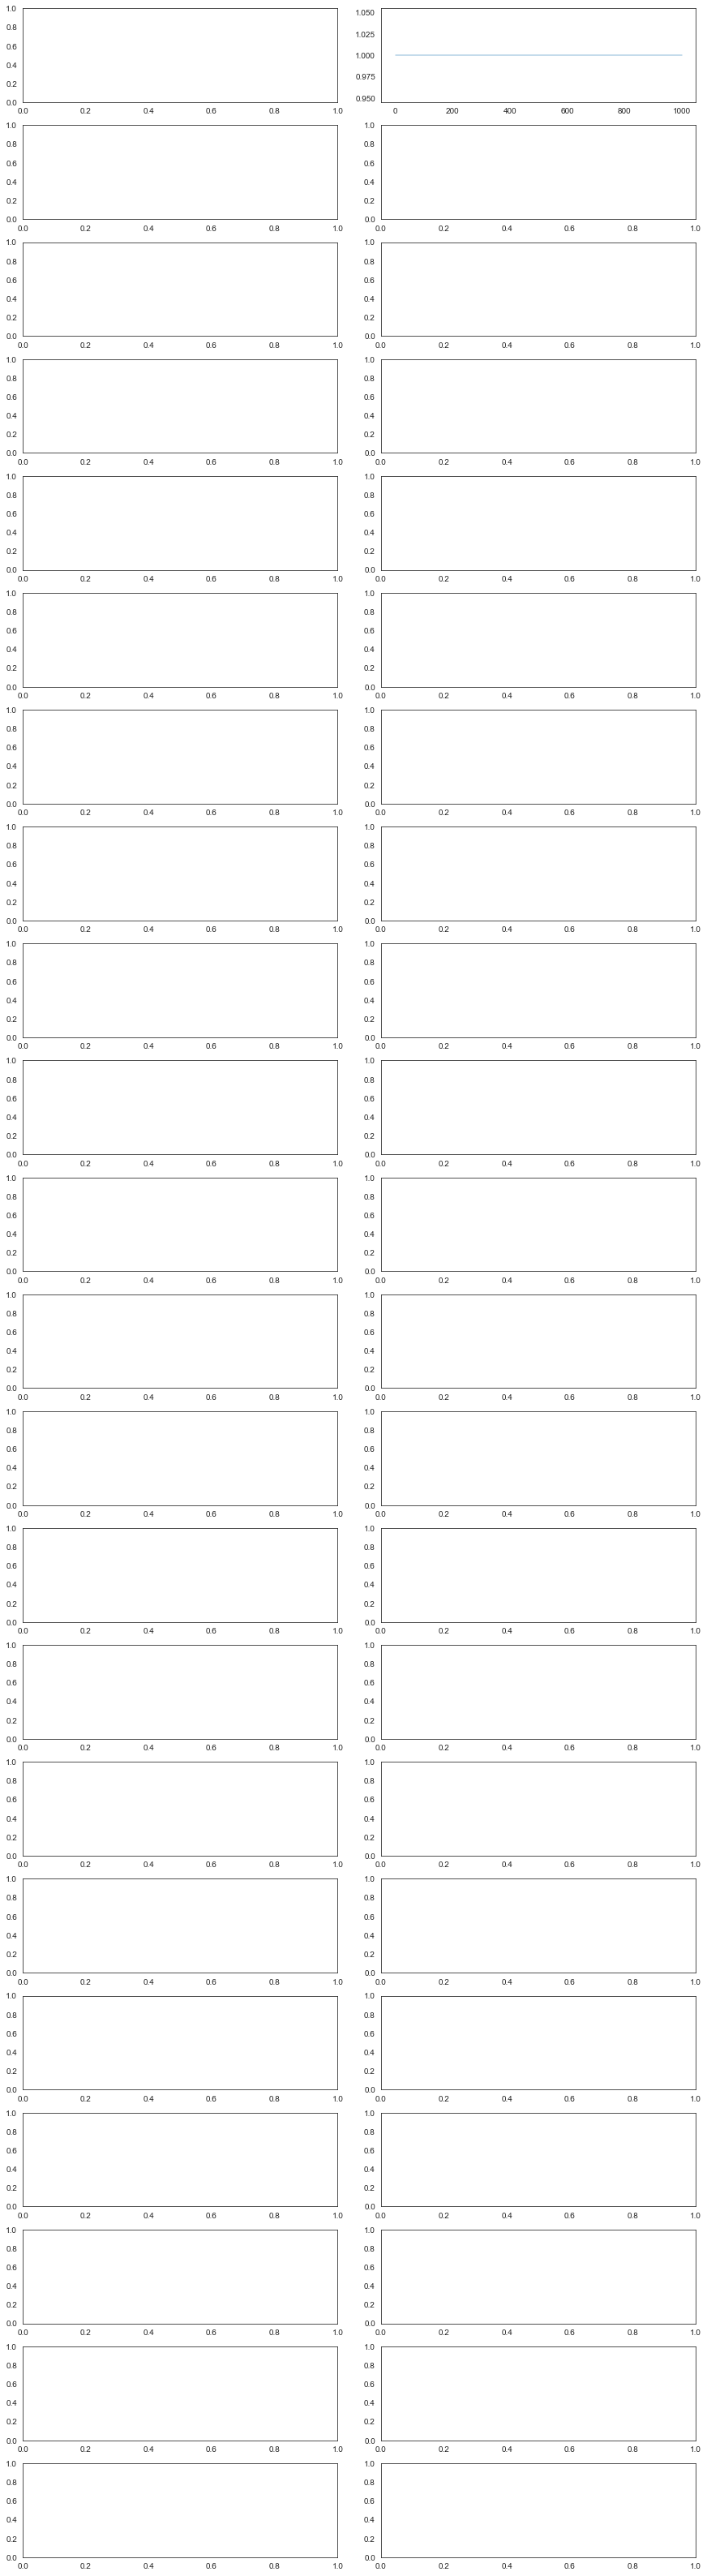

In [25]:
az.plot_trace(trace);

In [12]:
import scipy.stats

In [28]:
data = scipy.stats.multivariate_normal.rvs([1,2], 1, size= 2 * 10)
data.shape

(20, 2)

In [35]:
def bernoulli_mixture_loglh(mus, weights, K, N):
        def logp_(value):
            logps = []
            value_neg = 1 - value
            logmus = tt.log(mus)
            neglogmus = tt.log(1-mus)

            # N*K matrix of likelihood contributions from X_i with mu_k
            betas = tt.tensordot(value, logmus, axes=[1, 1]) + tt.tensordot(value_neg, neglogmus, axes=[1, 1])

            ## Form alphas, NxK matrix with the component weights included
            alphas = (betas + tt.log(weights)).T

            # Take LSE rowise to get N vector
            # and add alpha_cluster1 to get the total likelihood across all
            # components for each X_i
            lse_clust = pm.math.logsumexp(alphas - alphas[0, :], axis=0) + alphas[0,:]

            # Final overall sum
            return tt.sum(lse_clust)
        return logp_



In [36]:
K = 10

with pm.Model() as model: 
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    
    mu = pm.Beta('mu', 1, 1)
    obs = pm.DensityDist('obs', 
                         bernoulli_mixture_loglh(mu, w, K, N),
                         observed=data)

ValueError: axes[1] should be array_like with length less than the dimensions of b (b.ndim=0, len(axes[0])=1).

In [40]:
import pandas as pd

In [41]:
old_faithful_df = pd.read_csv(pm.get_data('old_faithful.csv'))
data = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()

In [64]:
N = old_faithful_df.shape[0]

K = 10

In [67]:
with pm.Model() as model2:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, observed=data)

In [68]:
with model2:    
    trace = pm.sample(1000, random_seed=23)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 2 chains:   0%|          | 0/3000 [00:00<?, ?draws/s]/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
obs   -inf


ParallelSamplingError: Bad initial energy

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


ValueError: cannot convert float NaN to integer

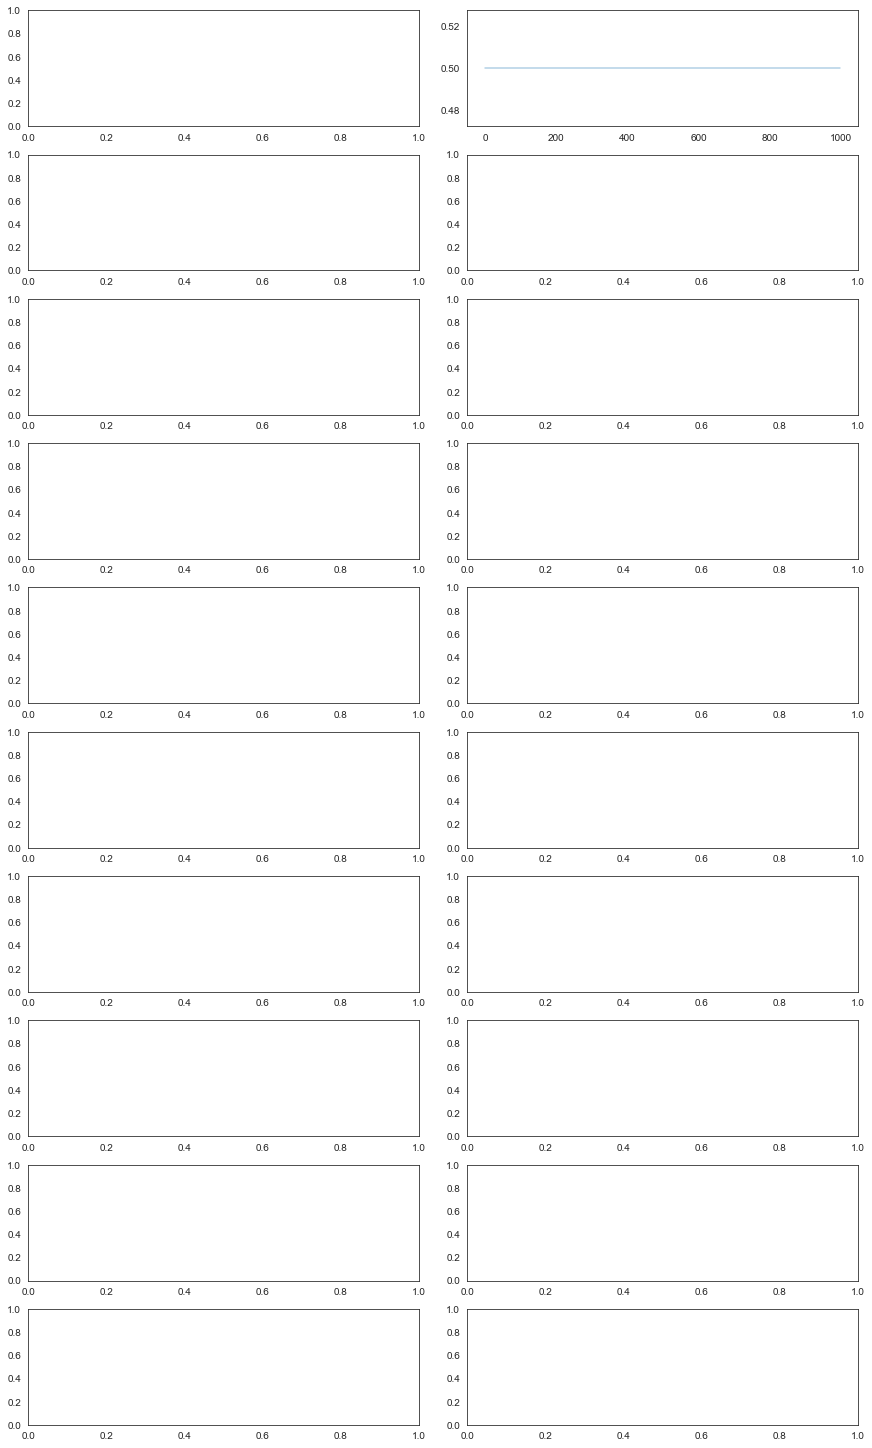

In [62]:
az.plot_trace(trace, var_names=['w']);